In [1]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [5]:

# set up the engine
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [8]:
#geting all films that were rented in May 2005:
query1 = '''SELECT DISTINCT(f.title) AS film_title
FROM sakila.film f 
LEFT JOIN sakila.inventory i 
USING (film_id)
LEFT JOIN sakila.rental r 
USING (inventory_id)
where rental_date BETWEEN '2005-05-01' AND '2005-05-31';'''

data1 = pd.read_sql_query(query1, engine)
data1.head()

,film_title
0,BLANKET BEVERLY
1,FREAKY POCUS
2,GRADUATE LORD
3,LOVE SUICIDES
4,IDOLS SNATCHERS


In [7]:
#get all films with the features to analyze
query2 = '''SELECT DISTINCT f.film_id, f.title, f.length, c.name, f.rental_duration, f.rental_rate
FROM sakila.film f
LEFT JOIN sakila.film_category fica 
ON f.film_id = fica.film_id
LEFT JOIN sakila.category c 
USING (category_id);'''

data2 = pd.read_sql_query(query2, engine)
data2.head()

,film_id,title,length,name,rental_duration,rental_rate
0,1,ACADEMY DINOSAUR,86,Documentary,6,0.99
1,2,ACE GOLDFINGER,48,Horror,3,4.99
2,3,ADAPTATION HOLES,50,Documentary,7,2.99
3,4,AFFAIR PREJUDICE,117,Horror,5,2.99
4,5,AFRICAN EGG,130,Family,6,2.99


In [9]:
#new column film was rented in may
import numpy as np
data2['rented_in_may'] = np.where(data2['title'].isin(data1['film_title']) ,1,0)
data2

,film_id,title,length,name,rental_duration,rental_rate,rented_in_may
0,1,ACADEMY DINOSAUR,86,Documentary,6,0.99,1
1,2,ACE GOLDFINGER,48,Horror,3,4.99,0
2,3,ADAPTATION HOLES,50,Documentary,7,2.99,0
3,4,AFFAIR PREJUDICE,117,Horror,5,2.99,1
4,5,AFRICAN EGG,130,Family,6,2.99,1
...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,183,Documentary,6,0.99,0
996,997,YOUTH KICK,179,Music,4,0.99,0
997,998,ZHIVAGO CORE,105,Horror,6,0.99,1
998,999,ZOOLANDER FICTION,101,Children,5,2.99,1


In [10]:
## drop film_id from our data2 as it is unique and we dont need it for our analysis 
data2 = data2.drop('film_id', axis=1)


In [11]:
## check types before spliting 
data2.dtypes


title               object
length               int64
name                object
rental_duration      int64
rental_rate        float64
rented_in_may        int32
dtype: object

In [12]:
## check nulls and clean should it be relevant 
data2.isna().sum()


title              0
length             0
name               0
rental_duration    0
rental_rate        0
rented_in_may      0
dtype: int64

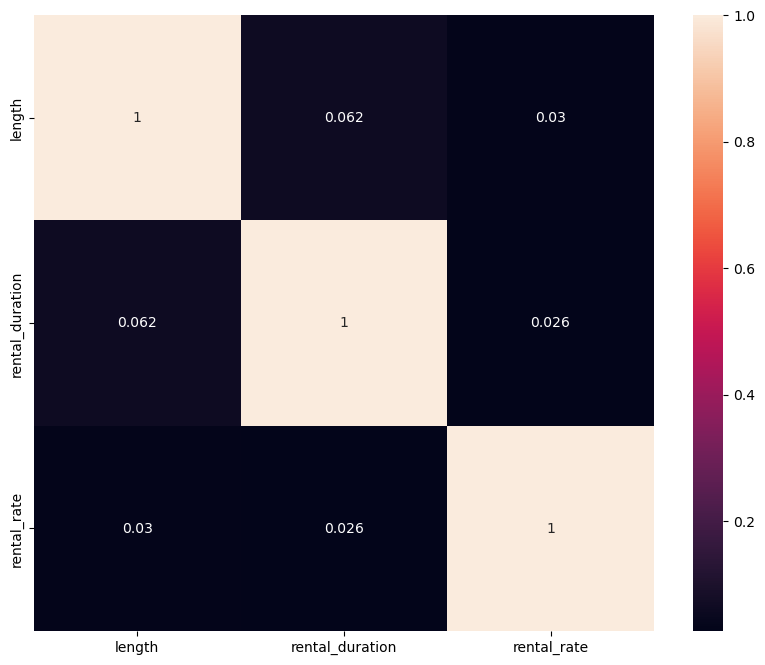

In [13]:
## corr check
import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix=data2.drop('rented_in_may', axis=1).corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [15]:
## x and y and train func 

y = data2['rented_in_may']
X = data2.drop(['rented_in_may', 'title'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
from sklearn.preprocessing import MinMaxScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns = X_train_num.columns)
X_train_norm

,length,rental_duration,rental_rate
0,0.172662,0.25,0.5
1,0.798561,0.50,1.0
2,0.496403,0.50,0.5
3,0.755396,0.25,1.0
4,0.460432,0.00,1.0
...,...,...,...
795,0.589928,0.50,1.0
796,0.884892,0.25,0.5
797,0.992806,1.00,0.0
798,0.834532,0.75,0.5


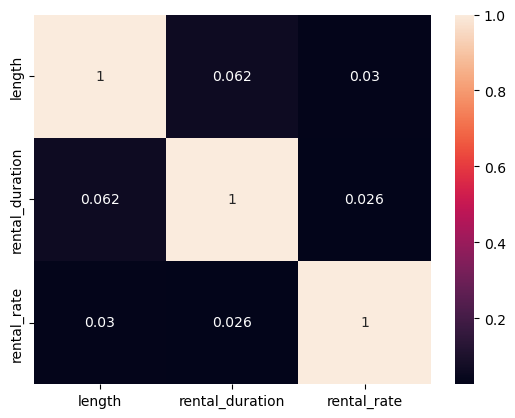

In [17]:
correlations_matrix = X.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

In [19]:
# OneHot Encoder for categoricals
from sklearn.preprocessing import OneHotEncoder

X_train_cat = X_train.select_dtypes(include = np.object)
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
all_columns = encoder.get_feature_names_out(input_features=X_train_cat.columns)
encoded = pd.DataFrame(encoder.transform(X_train_cat).toarray(), columns=all_columns)
encoded.head()

C:\Users\adyto\AppData\Local\Temp\ipykernel_22624\696303164.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train_cat = X_train.select_dtypes(include = np.object)


,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# build X_train and y_train
# remember: y = data['status'], y_train selected in train_test_split
X_train_transformed = np.concatenate([X_train_norm, encoded], axis=1)

In [21]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [23]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized, columns=X_test_num.columns)
X_test_norm

,length,rental_duration,rental_rate
0,0.949640,0.75,0.5
1,0.388489,0.50,0.5
2,0.172662,0.00,0.5
3,0.028777,0.00,1.0
4,0.906475,0.00,0.5
...,...,...,...
195,0.920863,1.00,0.0
196,0.446043,0.25,0.0
197,0.978417,1.00,1.0
198,0.122302,1.00,0.0


In [25]:
# for categoricals
X_test_cat = X_test.select_dtypes(include = np.object)
#encoder = OneHotEncoder(drop='first').fit(X_train_cat)
all_columns_test = encoder.get_feature_names_out(input_features=X_test_cat.columns)
encoded_test = pd.DataFrame(encoder.transform(X_test_cat).toarray(), columns=all_columns_test)
encoded_test.head()

C:\Users\adyto\AppData\Local\Temp\ipykernel_22624\479248085.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_cat = X_test.select_dtypes(include = np.object)


,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
X_test_transformed = np.concatenate([X_test_norm, encoded_test], axis=1)
X_test_transformed

array([[0.94964029, 0.75      , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.38848921, 0.5       , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.17266187, 0.        , 0.5       , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.97841727, 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12230216, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05755396, 0.25      , 1.        , ..., 0.        , 1.        ,
        0.        ]])

In [27]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized, columns=X_test_num.columns)
X_test_norm

,length,rental_duration,rental_rate
0,0.949640,0.75,0.5
1,0.388489,0.50,0.5
2,0.172662,0.00,0.5
3,0.028777,0.00,1.0
4,0.906475,0.00,0.5
...,...,...,...
195,0.920863,1.00,0.0
196,0.446043,0.25,0.0
197,0.978417,1.00,1.0
198,0.122302,1.00,0.0


In [28]:
# for categoricals
X_test_cat = X_test.select_dtypes(include = np.object)
#encoder = OneHotEncoder(drop='first').fit(X_train_cat)
all_columns_test = encoder.get_feature_names_out(input_features=X_test_cat.columns)
encoded_test = pd.DataFrame(encoder.transform(X_test_cat).toarray(), columns=all_columns_test)
encoded_test.head()

C:\Users\adyto\AppData\Local\Temp\ipykernel_22624\479248085.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_cat = X_test.select_dtypes(include = np.object)


,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:

# Now we can make predictions on the test set:
predictions = classification.predict(X_test_transformed)
predictions
classification.score(X_test_transformed, y_test)

0.61

In [30]:
print(y_test.value_counts())


1    124
0     76
Name: rented_in_may, dtype: int64


In [31]:
pd.Series(predictions).value_counts()


1    196
0      4
dtype: int64

In [ ]:
## The classification score is 68.5%. The Logistic Regression with multi_class = multinomial

In [32]:

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  1,  75],
       [  3, 121]], dtype=int64)

In [33]:
classification2 = LogisticRegression(solver='lbfgs').fit(X_train_transformed, y_train)
classification2

LogisticRegression()

In [34]:
predictions2 = classification2.predict(X_test_transformed)
classification2.score(X_test_transformed, y_test)

0.62

In [ ]:
## score a bit lower with  default value for multi_class